In [1]:
%pylab inline
import nest
import numpy as np
import matplotlib.pyplot as plot

Populating the interactive namespace from numpy and matplotlib


In [5]:
nest.helpdesk()

In [18]:
nest.ResetKernel()

# Part 3

In [19]:
""" settings"""
nest.SetDefaults("stdp_synapse",{"tau_plus": 15.0}) # change the default tau+ value
nest.CopyModel("stdp_synapse","layer1_stdp_synapse",{"Wmax": 90.0}) # config layer1 synapse

In [2]:
""" create nodes"""
# depression time constant of STDP is set by the neuron, not by the synapse
neuron1 = nest.Create("iaf_psc_alpha", params={"tau_minus": 30.0})

epop1 = nest.Create("iaf_psc_alpha", 10)

In [3]:
""" connect nodes with stochastic synapses"""
alpha_min = 0.1
alpha_max = 2.0
w_min = 0.5
w_max = 5.0
delay = 1.0

syn_dict = {"model": "stdp_synapse",
            "alpha": {"distribution": "uniform", "low": alpha_min, "high": alpha_max}, # uniform dist alpha val.
            "weight": {"distribution": "uniform", "low": w_min, "high": w_max}, #uniform dist weights
            "delay": delay}
nest.Connect(epop1, neuron1, "all_to_all", syn_dict)

In [7]:
""" checking connections"""
nest.GetConnections() # return all connections in the whole system
nest.GetConnections(target = neuron1) # all connection to neuron 1
nest.GetConnections(synapse_model="stdp_synapse") # all connection with certain syn_model
conns = nest.GetConnections(epop1, neuron1, "stdp_synapse") # mix all
nest.GetStatus(conns,"target")

(1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

# Ex 3

### 2)

In [8]:
""" the original script"""
# params
C  = 125
CE = int(0.8 * C)
CI = int(0.2 * C)
rate   = 10.0
nu_ext =  5.0

g     = -5.0
w_exc = 70.0
w_inh = g * w_exc
alpha = 1.1 # OK WHY

# check for addtive and multiplicative rules
mus = [0.0, 1.0] #[additive, multiplicative]
# mus = np.linspace(0.0,-3.0, 10) # find the critical value
weights = []
for muindex,mu in enumerate(mus):

    nest.ResetKernel()

    # create ndoes
    neuron = nest.Create("iaf_psc_alpha", 1, {"tau_minus": 20.0})

    pg_exc = nest.Create("poisson_generator", 1, {"rate": rate})
    inputs = nest.Create("parrot_neuron",CE)

    pg_inh = nest.Create("poisson_generator", 1, {"rate": CI * rate})
    pg_ext = nest.Create("poisson_generator", 1, {"rate": CE * nu_ext})

    # settings for the synapse
    nest.SetDefaults("stdp_synapse",{"tau_plus": 20.0,
                                     "mu_plus":  mu, # weight dep potent.
                                     "mu_minus": mu, # weight dep. depr.
                                     "alpha":    alpha,
                                     "lambda":   0.1,
                                     "Wmax":     2.0 * w_exc})

    # connect nodes
    nest.Connect(pg_exc, inputs, "all_to_all", {"weight":1.0, "delay":1.0,
                                                "model":"static_synapse"})
    nest.Connect(pg_inh, neuron, "all_to_all", {"weight":w_inh, "delay":1.0,
                                                "model":"static_synapse"})
    nest.Connect(pg_ext, neuron, "all_to_all", {"weight":w_exc, "delay":1.0,
                                                "model":"static_synapse"})
    nest.Connect(inputs, neuron, "all_to_all", {"weight":w_exc, "delay":1.0,
                                                "model":"stdp_synapse"}) # STDP
    
    # simulate
    burnin_time = 100000.0
    nest.Simulate(burnin_time)
    time = 100000.0
    recording_step = 1000.0
    # record every 1000 ms
    for t in np.arange(0.0, time+recording_step, recording_step):
        nest.Simulate(recording_step)
        conn = nest.GetConnections(inputs)
        weights = np.append(weights, nest.GetStatus(conn, "weight"))
weights_arr = np.reshape(weights, (muindex+1,CE,-1))

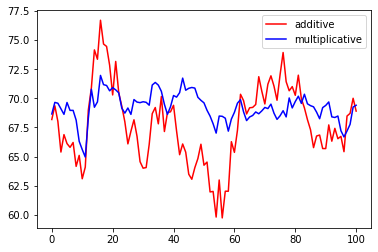

In [9]:
""" avg. weight of the STDP over time"""
plt.plot(np.mean(weights_arr[0], axis=0), "r", label="additive") # avg over diff connections
plt.plot(np.mean(weights_arr[1], axis=0), "b", label="multiplicative")
plt.legend()

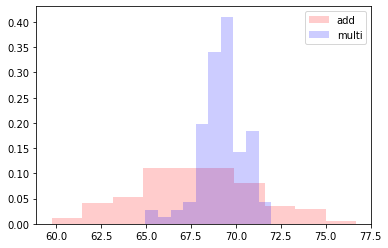

In [10]:
""" histogram"""
plt.hist(np.mean(weights_arr[0], axis=0), bins=10, density=True, alpha=0.2, color="r", label="add")
plt.hist(np.mean(weights_arr[1], axis=0), bins =10, density=True, alpha=0.2, color="b", label="multi")
plt.legend()

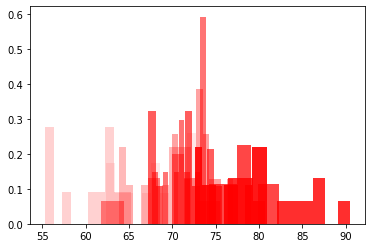

In [33]:
plot_hist = lambda data,index: plt.hist(np.mean(data, axis=0), bins=10, density=True, alpha = (index+1)/11, color="r")

for index, data in enumerate(weights_arr):
    plot_hist(data,index)

### 3)

In [12]:
""" synchronous firing"""
# params
C  = 125
CE = int(0.8 * C)
CI = int(0.2 * C)
rate   = 10.0
rate_stim = 2.0
nu_ext =  5.0
n_stim = 10

g     = -5.0
w_exc = 70.0
w_inh = g * w_exc
alpha = 1.1 

burnin_time = float(100000.0)
time = float(200000.0)
recording_step = float(1000.0)

# check for addtive and multiplicative rules
mus = [0.0, 1.0] #[additive, multiplicative]
# mus = np.linspace(0.1, -5.0, 10) # find the critical value
weights = []
for munindex,mu in enumerate(mus):

    nest.ResetKernel()
    
    # synapse settings
    nest.SetDefaults("stdp_synapse",{"tau_plus": 20.0,
                                     "mu_plus":  mu, # weight dep potent.
                                     "mu_minus": mu, # weight dep. depr.
                                     "alpha":    alpha,
                                     "lambda":   0.1,
                                     "Wmax":     2.0 * w_exc})
    
    # background
    pg_inh = nest.Create("poisson_generator", 1, {"rate": CI * rate})
    pg_ext = nest.Create("poisson_generator", 1, {"rate": CE * nu_ext})

    # target neuron
    neuron = nest.Create("iaf_psc_alpha", 1, {"tau_minus": 20.0})

    # rest of input neurons firing async.
    pg_exc = nest.Create("poisson_generator", 1, {"rate": rate})
    inputs_rest = nest.Create("parrot_neuron", CE-n_stim)
    # stim. input neurons
    pg_stim_before = nest.Create("poisson_generator", 1, {"rate": rate-rate_stim, "stop": burnin_time})
    inputs_stim_before = nest.Create("parrot_neuron", n_stim) # async firing before stim
    pg_stim_after = nest.Create("poisson_generator", 1, {"rate": rate_stim, "start": burnin_time})
    inputs_stim_after = nest.Create("parrot_neuron", n_stim) # sync firing after stim
    

    # connect nodes
    nest.Connect(pg_exc, inputs_rest, "all_to_all", {"weight":1.0, "delay":1.0,
                                                "model":"static_synapse"})
    nest.Connect(pg_stim_before, inputs_stim_before, "all_to_all", {"weight":1.0, "delay":1.0,
                                                "model":"static_synapse"})
    nest.Connect(pg_stim_after, inputs_stim_after, "all_to_all", {"weight":1.0, "delay":1.0,
                                                "model":"static_synapse"})
    
    nest.Connect(inputs_rest, neuron, "all_to_all", {"weight":w_exc, "delay":1.0,
                                                "model":"stdp_synapse"})
    nest.Connect(inputs_stim_before, neuron, "all_to_all", {"weight":w_exc, "delay":1.0,
                                                "model":"stdp_synapse"}) 
    nest.Connect(inputs_stim_after, neuron, "all_to_all", {"weight":w_exc, "delay":1.0,
                                                "model":"stdp_synapse"}) # STDP
    
    
    nest.Connect(pg_inh, neuron, "all_to_all", {"weight":w_inh, "delay":1.0,
                                                "model":"static_synapse"})
    nest.Connect(pg_ext, neuron, "all_to_all", {"weight":w_exc, "delay":1.0,
                                                "model":"static_synapse"})
    

    # simulate
    
    # record every 1000 ms
    for t in np.arange(0.0, burnin_time+recording_step, recording_step):
        nest.Simulate(recording_step)
        conn = nest.GetConnections(inputs_stim_before)
        weights = np.append(weights, nest.GetStatus(conn, "weight"))
    for t in np.arange(burnin_time, burnin_time+time+recording_step, recording_step):
        nest.Simulate(recording_step)
        conn = nest.GetConnections(inputs_stim_after)
        weights = np.append(weights, nest.GetStatus(conn, "weight"))
weights_arr = np.reshape(weights, (muindex+1,n_stim,-1))

In [17]:
np.mean(weights_arr[0], axis=0).shape

(402,)

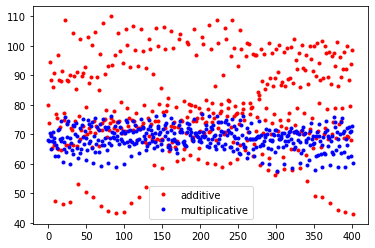

In [15]:
""" avg. weight of the STDP over time"""
plt.plot(np.mean(weights_arr[0], axis=0), "r.", label="additive") # avg over diff connections
plt.plot(np.mean(weights_arr[1], axis=0), "b.", label="multiplicative")
plt.legend()

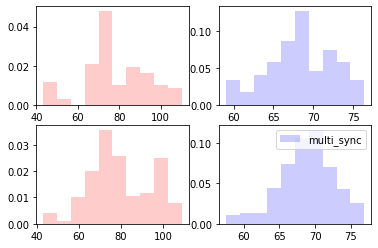

In [21]:
""" histogram"""
fig, axes = plt.subplots(nrows=2, ncols=2)
axes[0,0].hist(np.mean(weights_arr[0], axis=0)[:100], bins=10, density=True, alpha=0.2, color="r", label="add_async")
axes[0,1].hist(np.mean(weights_arr[1], axis=0)[:100], bins =10, density=True, alpha=0.2, color="b", label="multi_async")
axes[1,0].hist(np.mean(weights_arr[0], axis=0)[100:], bins =10, density=True, alpha=0.2, color="r", label="add_sync")
axes[1,1].hist(np.mean(weights_arr[1], axis=0)[100:], bins =10, density=True, alpha=0.2, color="b", label="multi_sync")
plt.legend()